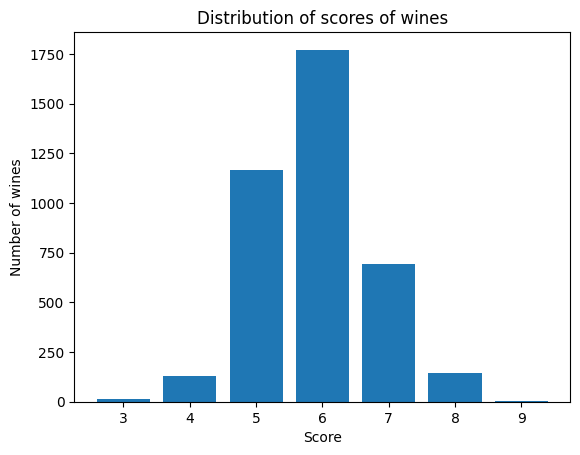

Average is 5.878764675855028
0.5639996173941925 0.5607292042283472


In [2]:
import numpy as np
import _pickle as cp
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn.preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

SPLIT_COEFFICIENT = 0.8
TRAINING_SIZE_MIN = 20
TRAINING_SIZE_MAX = 601
LAMBDA_POW_START = -10
LAMBDA_POW_END = 10
POLYNOMIAL_DEGREE = 2

def expand_with_ones(X):
    X_out = np.ones((X.shape[0], X.shape[1] + 1))
    X_out[:, 1:] = X
    return X_out


def load_data():
    X, y = cp.load(open('winequality-white.pickle', 'rb'))
    return X, y


# Arrays need to have the same length.
def split_data(X, y, split_coeff=None, train_size=None, test_size=None):
    N, _ = X.shape
    train_size = train_size if split_coeff is None else int(split_coeff * N)
    test_size = test_size if split_coeff is None else N - train_size
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    return X_train, y_train, X_test, y_test


def plot_bar_chart_score(X_train, y_train):
    fix, ax = plt.subplots()
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Score')
    plt.ylabel('Number of wines')
    plt.title('Distribution of scores of wines')
    plt.show()


def predict_simple(y_test):
    return y_test.mean()


def test_data(X_test, y_test, predictor: callable=None):
    # Applies function over rows.
    y_predicted = np.apply_along_axis(predictor, 1, X_test)
    mse = np.mean(np.square(np.subtract(y_predicted, y_test)))
    #print("Mean squared error is {}".format(mse))
    return mse


def standardize_data(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    # By default arithmetic operations work when you have A r b, it will
    # r each row of A with row of b.
    X_std = (X - mean) / std
    return X_std, mean, std


# Computes parameters using the closed form solution.
def least_squares_compute_parameters(X_in, y):
    X = expand_with_ones(X_in)
    T = np.matmul(X.transpose(), X)
    T = np.linalg.inv(T)
    T = np.matmul(T, X.transpose())
    T = np.matmul(T, y)
    return T


def predict_linear_model(x, w):
    return np.dot(x, w)


def train_and_test(X, y, split_coeff=None, train_size=None, test_size=None):
    X_train, y_train, X_test, y_test = split_data(X, y, split_coeff, train_size, test_size)
    X_train_std, mean, std = standardize_data(X_train)
    w = least_squares_compute_parameters(X_train_std, y_train)
    #print("***************************************")
    #print("")
    #print("")
    #print("Training linear model")
    mse_train = test_data(expand_with_ones(X_train_std), y_train,
              lambda x: predict_linear_model(x, w))

    #print("Testing linear model")
    X_test_std = (X_test - mean) / std
    mse_test = test_data(expand_with_ones(X_test_std), y_test,
              lambda x: predict_linear_model(x, w))
    return mse_train, mse_test


def train_and_test_regularized(X_train, y_train, X_test, y_test, lam, isRidge: bool):
    ridge_reg = lm.Ridge(alpha=lam) if isRidge else lm.Lasso(alpha=lam)

    ridge_reg.fit(X_train, y_train)
    mse_train = test_data(X_train, y_train, lambda x: np.dot(ridge_reg.coef_, x)
                                               + ridge_reg.intercept_)
    mse_test = test_data(X_test, y_test, lambda x: np.dot(ridge_reg.coef_, x)
                                               + ridge_reg.intercept_)
    return mse_train, mse_test


def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, isRidge: bool):
    mse_a = []
    lam_a = []
    for pow_lam in range(LAMBDA_POW_START, LAMBDA_POW_END):
        lam = 10 ** pow_lam
        _, mse = train_and_test_regularized(X_train_n, y_train_n,
                                            X_train_v, y_train_v, lam, isRidge)
        #print("Mean squared error for lambda {} is {}".format(lam, mse))
        mse_a.append(mse)
        lam_a.append(lam)
    lambda_idx_min = np.argmin(np.array(mse_a))
    print(lam_a[lambda_idx_min])
    plt.figure()
    plt.semilogx(lam_a, mse_a)
    return lam_a[lambda_idx_min]


if __name__ == "__main__":
    X, y = load_data()
    #print(X)
    #print(y)
    X_train, y_train, X_test, y_test = split_data(X, y, SPLIT_COEFFICIENT)
    plot_bar_chart_score(X_train, y_train)
    print("Average is {}".format(predict_simple(y_train)))
    test_data(X_test, y_test, lambda x: predict_simple(y_train))


    mse_train, mse_test = train_and_test(X, y, SPLIT_COEFFICIENT)
    mse_train_v = []
    mse_test_v = []
    print(mse_train, mse_test)




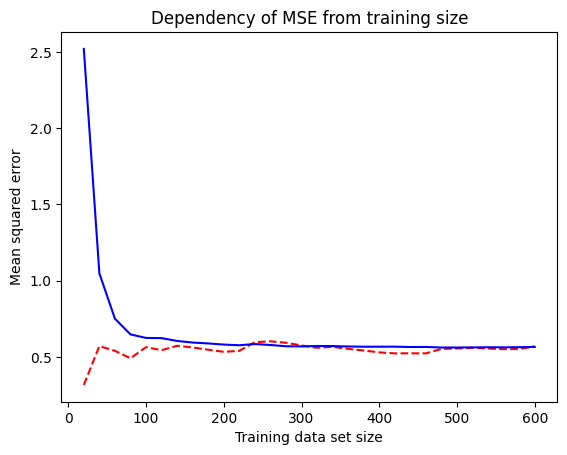

In [3]:
    for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
        mse_train, mse_test = train_and_test(X, y, None, train_size, 980)
        #print("Data set size".format(train_size))
        #print("Mse train{}".format(mse_train))
        #print("Mse test{}".format(mse_test))
        mse_train_v.append(mse_train)
        mse_test_v.append(mse_test)
    # TODO: Add legend.
    plt.figure(2)
    plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--',
             np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-')
    plt.xlabel('Training data set size')
    plt.ylabel('Mean squared error')
    plt.title('Dependency of MSE from training size')
    plt.show()



Ridge regression
0.0001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.867e+02, tolerance: 2.424e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.867e+02, tolerance: 2.424e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.867e+02, tolerance: 2.424e

0.0001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.487e+02, tolerance: 3.043e-01
  model = cd_fast.enet_coordinate_descent(


Train mean squared error for ridge is 0.4954289413363039, test is 0.5110613785156736
Train mean squared error for lasso is 0.5070723368950788, test is 0.5225231683801574


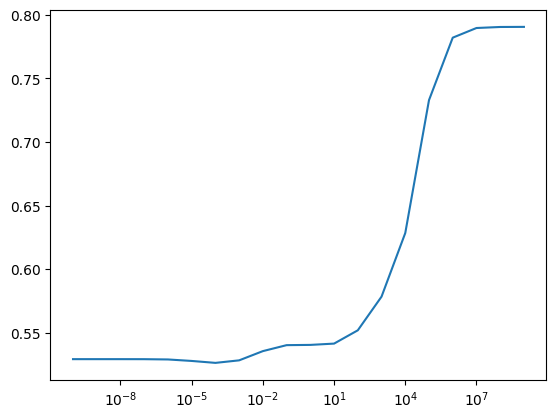

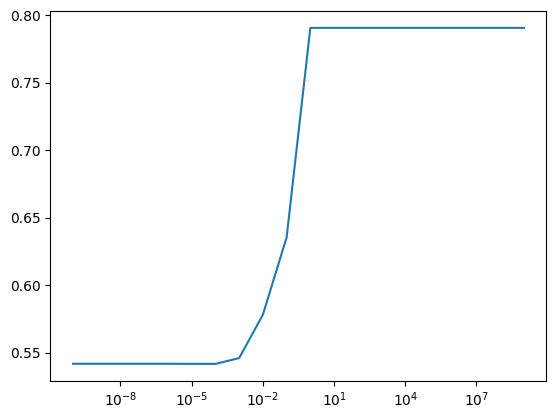

In [4]:

    std_scaler = StandardScaler()
    poly_feat = PolynomialFeatures(POLYNOMIAL_DEGREE)
    X_poly = poly_feat.fit_transform(X)
    X_train, y_train, X_test, y_test = split_data(X_poly, y, SPLIT_COEFFICIENT)

    X_train_n, y_train_n, X_train_v, y_train_v = \
        split_data(X_train, y_train, SPLIT_COEFFICIENT)
    std_scaler.fit(X_train_n)
    X_train_n = std_scaler.transform(X_train_n)
    X_train_v = std_scaler.transform(X_train_v)

    print("")
    print("Ridge regression")
    lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
    lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

    std_scaler.fit(X_train)
    X_train = std_scaler.transform(X_train)
    X_test = std_scaler.transform(X_test)
    mse_train_r, mse_test_r = train_and_test_regularized(X_train, y_train, X_test,
                                                         y_test, lam_ridge, True)
    mse_train_l, mse_test_l = train_and_test_regularized(X_train, y_train, X_test,
                                                         y_test, lam_ridge, False)
    print("Train mean squared error for ridge is {}, test is {}".
          format(mse_train_r, mse_test_r))
    print("Train mean squared error for lasso is {}, test is {}".
          format(mse_train_l, mse_test_l))


    plt.show()